<a href="https://colab.research.google.com/github/JScottLopez/JScottLopez/blob/main/Lopez_J_DDS_8555v1_Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Author: Joseph Lopez
#3/15/2025

#Install preliminary libraries
from sklearn import datasets
import pandas as pd
import numpy as np

#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

#Load data from a CSV file
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')

Mounted at /content/drive


In [ ]:
#Use one hot encoding to sub numerical values for categorical values
train = pd.get_dummies(train, columns=['Sex'], dtype=int)
test = pd.get_dummies(test, columns=['Sex'], dtype=int)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#Ensure output meets submission requirements
target_size = 60411
if len(train) > target_size:
  train = train.sample(n=target_size, random_state=42)

#Subset columns
X = train.drop('Rings', axis=1)
y = train['Rings']

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Create polynomial features
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train_scaled)
X_test_poly = poly_features.transform(X_test_scaled)

#Train model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

#Make predictions
y_pred = poly_model.predict(X_test_poly)

#Calculate MAPE
def calculate_mape(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = calculate_mape(y_test, y_pred)

#Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"MAPe: {mape}")
print(f"R-squared: {r2:}")

Mean Squared Error: 3.697336382178535
MAPe: 13.613790178193744
R-squared: 0.6321830468289409


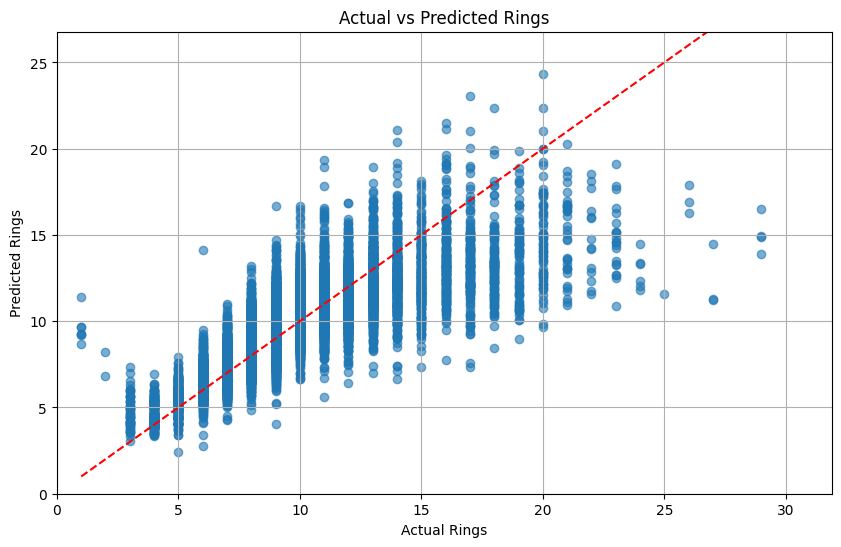

In [ ]:
#Plot results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.title('Actual vs Predicted Rings')
plt.xlim([0, max(y_test)*1.1])
plt.ylim([0, max(y_pred)*1.1])
plt.grid()
plt.show()

In [ ]:
#Use Polynomial model
test_data_for_prediction = test[X_train.columns]
submission5 = pd.DataFrame({'id': test['id'], 'Rings': poly_model.predict(poly_features.transform(scaler.transform(test_data_for_prediction)))})
submission5.to_csv('submission5.csv', index=False)
print(submission5)

#Convert output to CSV file
submission5.to_csv('submission4.csv', index=False)

           id      Rings
0       90615   9.272091
1       90616   9.718873
2       90617  10.526667
3       90618   9.962800
4       90619   7.642116
...       ...        ...
60406  151021   6.408408
60407  151022   9.380254
60408  151023  11.530020
60409  151024  12.867410
60410  151025   8.654114

[60411 rows x 2 columns]


In [ ]:
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from scipy.interpolate import interp1d

#Ensure output meets submission requirements
target_size = 60411
if len(train) > target_size:
  train = train.sample(n=target_size, random_state=42)

#Subset columns
A = train.drop('Rings', axis=1)
b = train['Rings']

#Split data
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=42)

#Calculate lowess spline values
lowess_result_train_length = sm.nonparametric.lowess(b_train, A_train['Length'], frac=0.1, return_sorted=False)
lowess_result_test_length = sm.nonparametric.lowess(b_test, A_test['Length'], frac=0.1, return_sorted=False)
lowess_result_train_height = sm.nonparametric.lowess(b_train, A_train['Height'], frac=0.1, return_sorted=False)
lowess_result_test_height = sm.nonparametric.lowess(b_test, A_test['Height'], frac=0.1, return_sorted=False)

#Assign spline values
A_train['Length_spline'] = lowess_result_train_length
A_test['Length_spline'] = lowess_result_test_length
A_train['Height_spline'] = lowess_result_train_height
A_test['Height_spline'] = lowess_result_test_height

#Scale features
scaler = StandardScaler()
A_train_scaled = scaler.fit_transform(A_train)
A_test_scaled = scaler.transform(A_test)

In [ ]:
#Use Length and Height feature
spline_features = PolynomialFeatures(degree=3, include_bias=False)
spline_features.fit(A_train[['Length_spline','Height_spline']])

#Calculate lowess spline values
lowess_result_A_length = sm.nonparametric.lowess(b, A['Length'], frac=0.1, return_sorted=False)
lowess_result_A_height = sm.nonparametric.lowess(b, A['Height'], frac=0.1, return_sorted=False)
A['Length_spline'] = lowess_result_A_length
A['Height_spline'] = lowess_result_A_height

#Add constant column
A = sm.add_constant(A)

#Fit model and print summary statistics
spline_model = sm.GLM(
    b, A[['const', 'Length_spline', 'Height_spline']], family=sm.families.Gaussian()
).fit()
print(spline_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Rings   No. Observations:                60411
Model:                            GLM   Df Residuals:                    60408
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                          5.5161
Method:                          IRLS   Log-Likelihood:            -1.3730e+05
Date:                Sun, 16 Mar 2025   Deviance:                   3.3322e+05
Time:                        01:03:56   Pearson chi2:                 3.33e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5669
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.3728      0.053    -25.787

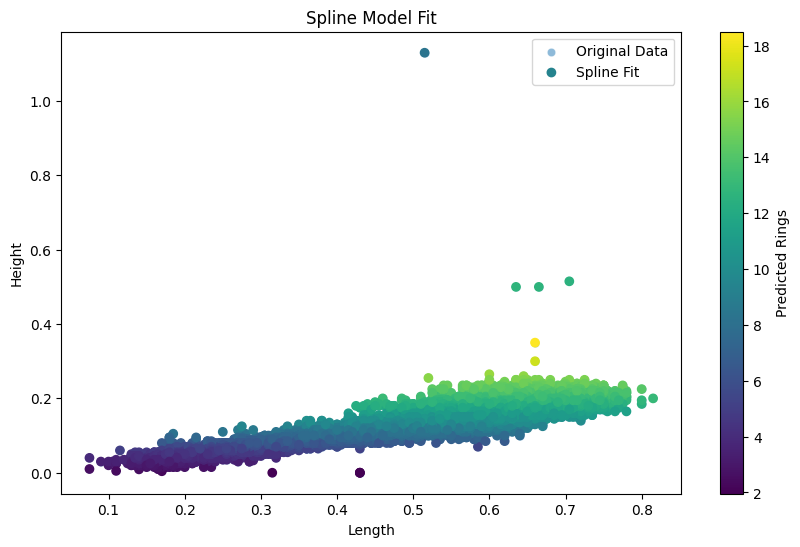

In [ ]:
#Plot results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=A['Length'], y=A['Height'], label='Original Data', alpha=0.5)
X_pred = sm.add_constant(A[['Length_spline', 'Height_spline']], has_constant='add')
y_pred = spline_model.predict(X_pred)
plt.scatter(A['Length'], A['Height'], c=y_pred, cmap='viridis', label='Spline Fit')
plt.title('Spline Model Fit')
plt.xlabel('Length')
plt.ylabel('Height')
plt.colorbar(label='Predicted Rings')
plt.legend()
plt.show()

In [ ]:
#Ensure output meets submission requirements
if len(test) > target_size:
  test = test.sample(n=target_size, random_state=42)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

#Create Lowess functions
length_lowess_func = sm.nonparametric.lowess(b, A['Length'], frac=0.1, return_sorted=True)
height_lowess_func = sm.nonparametric.lowess(b, A['Height'], frac=0.1, return_sorted=True)

#Create interpolations functions for test data
length_interp = interp1d(length_lowess_func[:, 0], length_lowess_func[:, 1], kind='linear', fill_value='extrapolate')
height_interp = interp1d(height_lowess_func[:, 0], height_lowess_func[:, 1], kind='linear', fill_value='extrapolate')
test['Length_spline'] = length_interp(test['Length'])
test['Height_spline'] = height_interp(test['Height'])
test[['Length_spline', 'Height_spline']] = imputer.fit_transform(test[['Length_spline', 'Height_spline']])

#Make predictions
test_data_for_prediction = test[A_train.columns]
test_data_length_spline = test_data_for_prediction[['Length_spline', 'Height_spline']]

#Transform test data
transformed_test_data = spline_features.transform(test_data_length_spline)

/usr/local/lib/python3.11/dist-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [ ]:
#Evaluate model
test_predictions = spline_model.predict(sm.add_constant(A_test[['Length_spline', 'Height_spline']], has_constant='add'))
test_predictions = np.maximum(test_predictions, 0)
mse = mean_squared_error(b_test, test_predictions)
r2 = r2_score(b_test, test_predictions)
print(f"\nMean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")


Mean Squared Error (MSE): 5.3939
R-squared (R2): 0.4634


In [ ]:
#Use Spline model to make predictions
submission6 = pd.DataFrame({'id': test['id'], 'Rings': np.maximum(spline_model.predict(sm.add_constant(
    test_data_length_spline, has_constant='add')), 0)})
submission6.to_csv('submission6.csv', index=False)
print(submission6)

#Convert output to CSV files
submission6.to_csv('submission6.csv', index=False)

           id      Rings
0       90615  11.012797
1       90616  10.969966
2       90617  10.051075
3       90618  10.635241
4       90619   8.299061
...       ...        ...
60406  151021   6.730774
60407  151022  10.671329
60408  151023  11.028947
60409  151024  12.612676
60410  151025   8.882055

[60411 rows x 2 columns]
